In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Q1
# Load and rename columns
df = pd.read_csv('Concrete_Data.csv')

# Rename long column names to short readable ones
df.columns = [
    'Cement', 'Slag', 'FlyAsh', 'Water', 'Superplasticizer',
    'CoarseAggregate', 'FineAggregate', 'Age', 'Strength'
]

df.head()

,Cement,Slag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
# Split train/test sets by row index
test_df = df.iloc[501:631]
train_df = df.drop(df.index[501:631])

y_train = train_df['Strength'].values
y_test = test_df['Strength'].values

In [4]:
# Q1.1 Set 1
# Gradient descent for univariate linear regression
def gd_univariate(x, y, lr=0.03, n_iters=5000):
    # y_hat = m*x + b; minimize MSE
    m, b = 0.0, 0.0
    n = len(x)
    for _ in range(n_iters):
        y_hat = m*x + b
        dm = (-2/n) * np.sum(x * (y - y_hat))  # gradient for m
        db = (-2/n) * np.sum(y - y_hat)        # gradient for b
        m -= lr * dm
        b -= lr * db
    return m, b

def mse(y, yhat):
    return np.mean((y - yhat)**2)

def r2(y, yhat):
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res/ss_tot

In [5]:
# Train 8 predictors and pick best by TRAIN R²
predictors=['Cement','Slag','FlyAsh','Water','Superplasticizer',
            'CoarseAggregate','FineAggregate','Age']
lrs=[0.005,0.01,0.02,0.03,0.05]
iters=[2000,5000,10000,20000]
results=[]

for pred in predictors:
    scaler=StandardScaler()
    Xtr=scaler.fit_transform(train_df[[pred]]).ravel()   # fit on TRAIN
    Xte=scaler.transform(test_df[[pred]]).ravel()        # transform TEST
    best=None
    for lr in lrs:
        for it in iters:
            m,b=gd_univariate(Xtr,y_train,lr=lr,n_iters=it)
            ytr,yte=m*Xtr+b, m*Xte+b
            rec={'Pred':pred,'lr':lr,'iters':it,'m':m,'b':b,
                 'MSE_tr':mse(y_train,ytr),'R2_tr':r2(y_train,ytr),
                 'MSE_te':mse(y_test,yte),'R2_te':r2(y_test,yte)}
            if (best is None) or (rec['R2_tr']>best['R2_tr']):
                best=rec
    results.append(best)

table=pd.DataFrame(results)
print("\nBest per predictor (trained with z-score X; sorted by Test R²):")
print(table.to_string(index=False))


Best per predictor (trained with z-score X; sorted by Test R²):
            Pred    lr  iters         m      b     MSE_tr    R2_tr     MSE_te     R2_te
          Cement 0.005   2000  8.576303 36.972 203.527354 0.265457 268.103305 -0.231305
            Slag 0.050   2000  2.622250 36.972 270.204129 0.024817 309.086336 -0.419525
          FlyAsh 0.005   5000 -3.425128 36.972 265.348821 0.042340 382.789302 -0.758017
           Water 0.030   2000 -4.586169 36.972 256.047375 0.075909 260.305841 -0.195494
Superplasticizer 0.030   2000  5.276505 36.972 249.238818 0.100482 195.642298  0.101483
 CoarseAggregate 0.020   2000 -2.128654 36.972 272.549158 0.016353 275.934471 -0.267271
   FineAggregate 0.005   5000 -2.507650 36.972 270.792016 0.022695 283.227283 -0.300764
             Age 0.005   5000  5.821494 36.972 243.190535 0.122310 298.418106 -0.370530


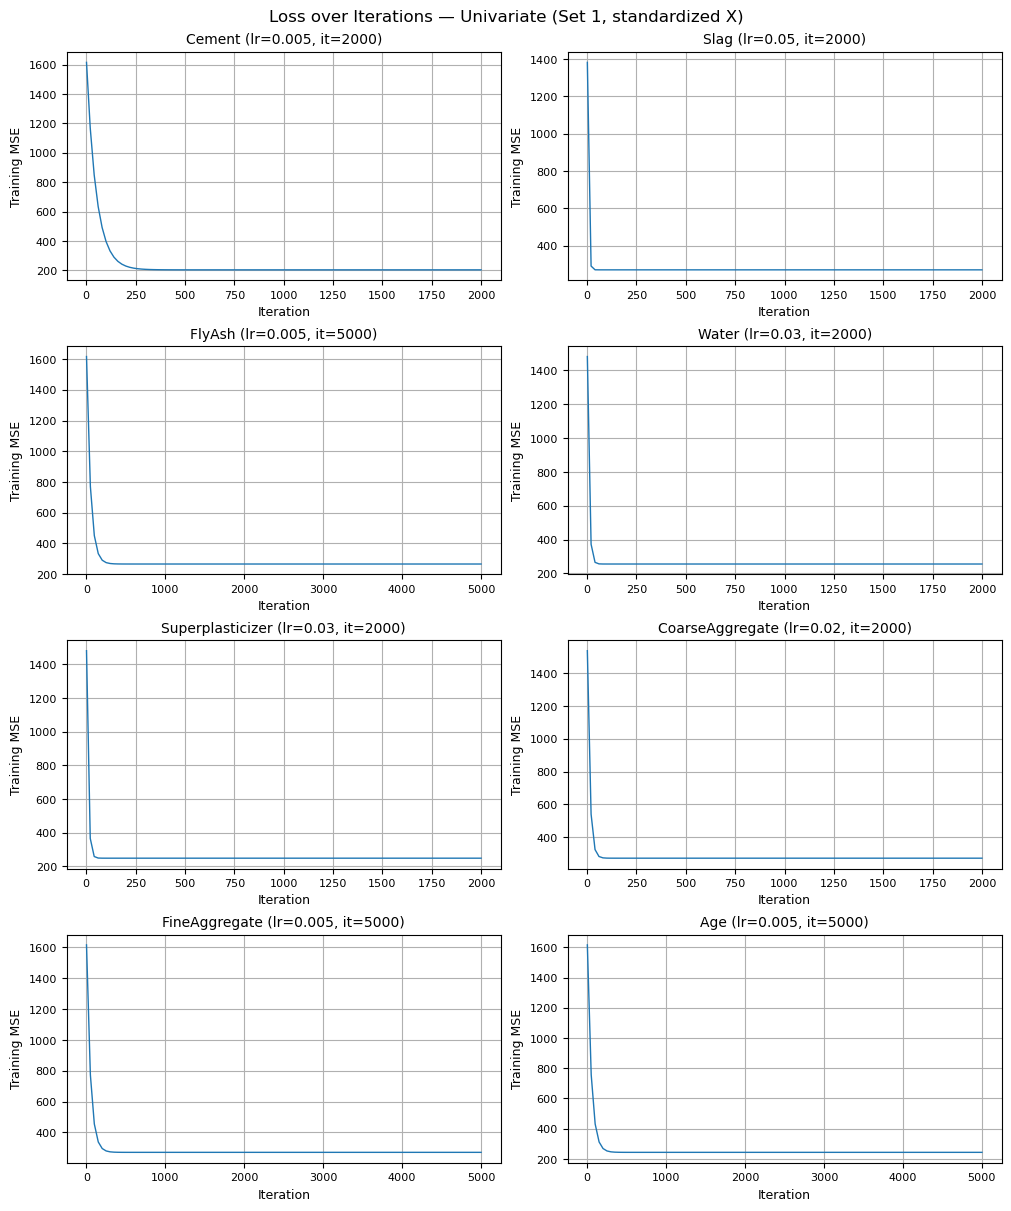

In [6]:
def gd_univariate_log(x, y, lr=0.03, n_iters=5000, log_every=100):
    m, b = 0.0, 0.0
    n = len(x)
    hist = []
    for it in range(1, n_iters + 1):
        y_hat = m * x + b
        dm = (-2/n) * np.sum(x * (y - y_hat))  # grad for m
        db = (-2/n) * np.sum(y - y_hat)        # grad for b
        m -= lr * dm
        b -= lr * db
        if (it % log_every == 0) or (it == 1):
            mse = np.mean((y - (m * x + b))**2)
            hist.append((it, mse))
    return m, b, hist

# Plot loss curves for 8 predictors (standardized X)
fig, axes = plt.subplots(4, 2, figsize=(10, 12), constrained_layout=True)
axes = axes.flatten()

for i, pred in enumerate(predictors):
    best = table.loc[table['Pred'] == pred].iloc[0]
    lr, iters = float(best['lr']), int(best['iters'])
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(train_df[[pred]]).ravel()
    log_every = max(1, iters // 100)
    _, _, hist = gd_univariate_log(Xtr, y_train, lr=lr, n_iters=iters, log_every=log_every)

    its = [t for t, _ in hist]
    mses = [v for _, v in hist]
    ax = axes[i]
    ax.plot(its, mses, linewidth=1)
    ax.set_title(f"{pred} (lr={lr:g}, it={iters})", fontsize=10)
    ax.set_xlabel("Iteration", fontsize=9)
    ax.set_ylabel("Training MSE", fontsize=9)
    ax.grid(True)
    ax.tick_params(labelsize=8)

plt.suptitle("Loss over Iterations — Univariate (Set 1, standardized X)", fontsize=12)
fig.savefig("loss_grid_univariate_set1.png", dpi=300)
plt.show()

In [7]:
# Q1.2 Set2: RAW X & RAW y, pick by TRAIN R² 
predictors = ['Cement','Slag','FlyAsh','Water','Superplasticizer',
              'CoarseAggregate','FineAggregate','Age']

# tiny LRs for raw-scale features + longer iters
lrs   = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4]
iters = [50_000, 100_000, 200_000]

results = []
for p in predictors:
    Xtr = train_df[[p]].values.ravel()   # RAW X
    Xte = test_df[[p]].values.ravel()    # RAW X
    best = None
    for lr in lrs:
        for it in iters:
            m, b = gd_univariate(Xtr, y_train, lr=lr, n_iters=it)
            ytr, yte = m*Xtr + b, m*Xte + b
            rec = {'Pred':p,'lr':lr,'iters':it,'m':m,'b':b,
                   'MSE_tr':mse(y_train,ytr),'R2_tr':r2(y_train,ytr),
                   'MSE_te':mse(y_test,yte),'R2_te':r2(y_test,yte)}
            if (best is None) or (rec['R2_tr'] > best['R2_tr']):
                best = rec
    results.append(best)

table = pd.DataFrame(results)
print("\nBest per predictor (RAW X; sorted by Test R²):")
print(table.to_string(index=False))

E:\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19952\3268423658.py:11: RuntimeWarning: invalid value encountered in scalar subtract
  m -= lr * dm
E:\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19952\3268423658.py:8: RuntimeWarning: invalid value encountered in multiply
  y_hat = m*x + b
E:\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19952\3268423658.py:11: RuntimeWarning: invalid value encountered in scalar subtract
  m -= lr * dm
E:\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: ov


Best per predictor (RAW X; sorted by Test R²):
            Pred       lr  iters         m         b     MSE_tr     R2_tr     MSE_te     R2_te
          Cement 0.000010 200000  0.108146  5.780914 213.194973  0.230566 257.221113 -0.181327
            Slag 0.000050 200000  0.031218 34.594763 270.204129  0.024817 309.082746 -0.419509
          FlyAsh 0.000100 200000 -0.053323 40.038902 265.348821  0.042340 382.789302 -0.758017
           Water 0.000010 200000  0.174928  4.310154 329.094167 -0.187721 327.779491 -0.505377
Superplasticizer 0.000100 200000  0.883056 30.906584 249.238818  0.100482 195.642285  0.101483
 CoarseAggregate 0.000001 200000  0.037404  0.160510 298.004378 -0.075516 344.013514 -0.579934
   FineAggregate 0.000001 200000  0.046663  0.269040 311.286702 -0.123453 332.623875 -0.527625
             Age 0.000100 200000  0.094991 32.598183 243.190535  0.122310 298.418106 -0.370530


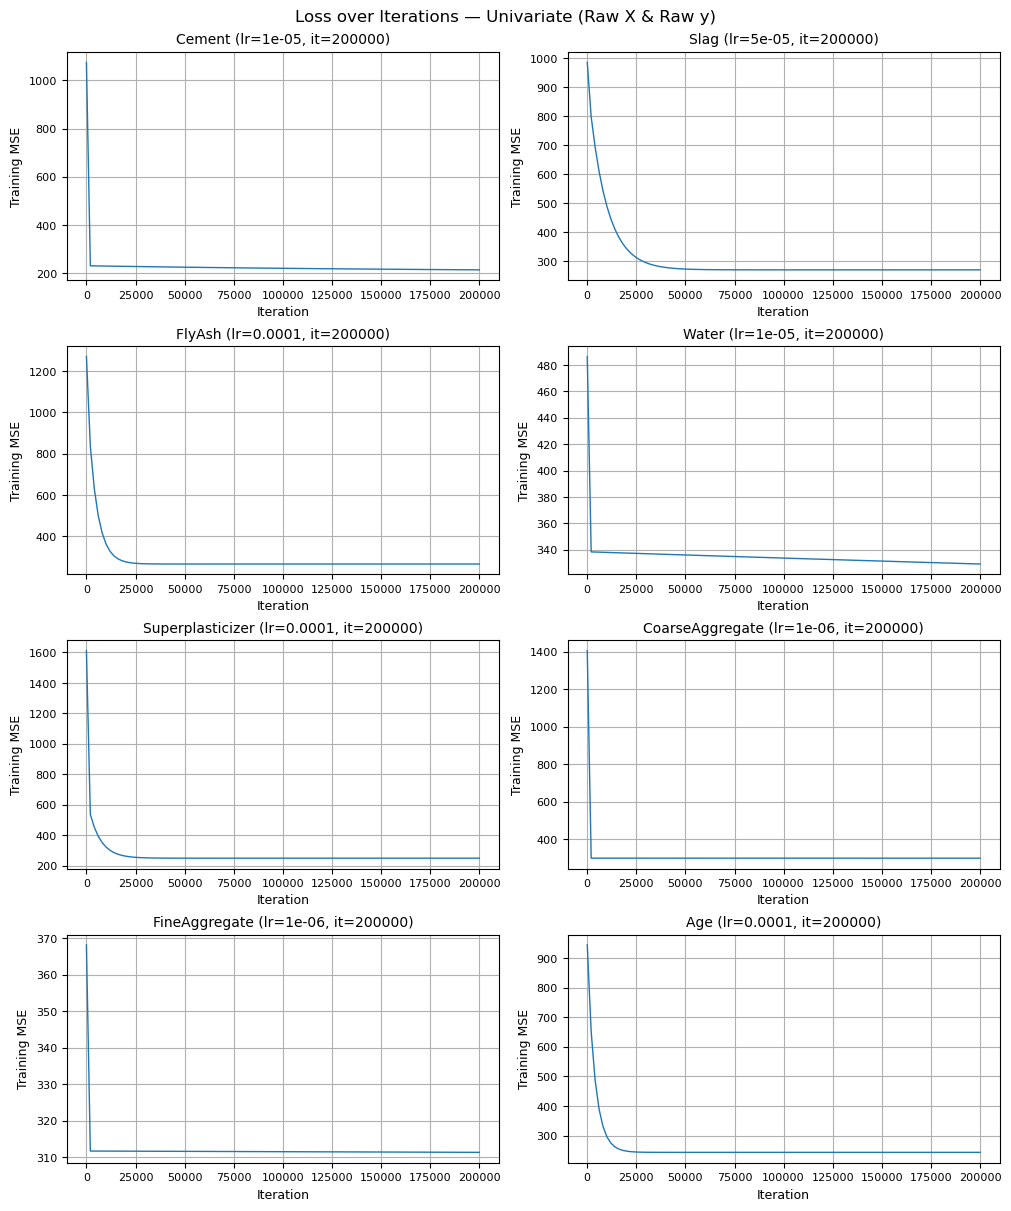

In [8]:
def gd_univariate_log(x, y, lr=0.03, n_iters=5000, log_every=100):
    m, b = 0.0, 0.0
    n = len(x)
    hist = []
    for it in range(1, n_iters + 1):
        y_hat = m * x + b
        dm = (-2/n) * np.sum(x * (y - y_hat))  # grad for m
        db = (-2/n) * np.sum(y - y_hat)        # grad for b
        m -= lr * dm
        b -= lr * db
        if (it % log_every == 0) or (it == 1):
            mse = np.mean((y - (m * x + b))**2)
            hist.append((it, mse))
    return m, b, hist

# Plot loss curves for 8 predictors (Raw X & Raw y)
fig, axes = plt.subplots(4, 2, figsize=(10, 12), constrained_layout=True)
axes = axes.flatten()

for i, pred in enumerate(predictors):
    best = table.loc[table['Pred'] == pred].iloc[0]
    lr, iters = float(best['lr']), int(best['iters'])
    Xtr = train_df[[pred]].values.ravel()
    log_every = max(1, iters // 100)
    m, b, hist = gd_univariate_log(Xtr, y_train, lr=lr, n_iters=iters, log_every=log_every)

    its = [t for t, _ in hist]
    mses = [v for _, v in hist]
    ax = axes[i]
    ax.plot(its, mses, linewidth=1)
    ax.set_title(f"{pred} (lr={lr:g}, it={iters})", fontsize=10)
    ax.set_xlabel("Iteration", fontsize=9)
    ax.set_ylabel("Training MSE", fontsize=9)
    ax.grid(True)
    ax.tick_params(labelsize=8)

plt.suptitle("Loss over Iterations — Univariate (Raw X & Raw y)", fontsize=12)
plt.show()

In [9]:
# Q2.1
x = np.array([3, 4, 5])
y = 4

w = np.array([1, 1, 1])
b = 1.0

alpha = 0.1

y_hat = float(np.dot(w, x) + b)

err = y_hat - y
grad_w = 2.0 * x * err
grad_b = 2.0 * err

# GD update
w_new = w - alpha * grad_w
b_new = b - alpha * grad_b

print("Updated weights:", w_new)
print("Updated bias:", b_new)

Updated weights: [-4.4 -6.2 -8. ]
Updated bias: -0.8


In [10]:
# Q2.2
X = np.array([
    [ 3.0, 4.0, 4.0],
    [ 4.0, 2.0, 1.0],
    [10.0, 2.0, 5.0],
    [ 3.0, 4.0, 5.0],
    [11.0, 1.0, 1.0],
])
y = np.array([3.0, 2.0, 8.0, 4.0, 5.0])

w = np.array([1, 1, 1])
b = 1.0
alpha = 0.1

# predict with initial params
y_hat = X.dot(w) + b
err = y_hat - y

n = len(y)
grad_w = (2.0 / n) * X.T.dot(err)
grad_b = (2.0 / n) * err.sum()

w_new = w - alpha * grad_w
b_new = b - alpha * grad_b

print("\nUpdated weights:", w_new)
print("Updated bias:", b_new)


Updated weights: [-10.08  -3.52  -4.84]
Updated bias: -0.72


In [11]:
# Q2.3 Set 1
# Multivariate GD (batch) for linear regression
def gd_multivariate(X, y, lr=0.05, n_iters=10000, decay=None, tol=1e-8):
    """
    decay: None | 'sqrt' | '1/t'  (optional LR decay)
    """
    n, d = X.shape
    w = np.zeros(d)   # start from zeros
    b = 0.0
    last = np.inf
    for t in range(1, n_iters+1):
        yhat = X @ w + b
        err  = yhat - y
        dw = (2.0/n) * (X.T @ err)
        db = (2.0/n) * np.sum(err)

        # simple LR schedule
        if decay == 'sqrt':
            lr_t = lr / np.sqrt(t)
        elif decay == '1/t':
            lr_t = lr / t
        else:
            lr_t = lr

        w -= lr_t * dw
        b -= lr_t * db

        # early stop check (every 100 iters)
        if t % 100 == 0:
            L = mse(y, X @ w + b)
            if abs(last - L) < tol:
                break
            last = L
    return w, b

In [12]:
# 8 predictors, standardized X, raw y
X_cols = ['Cement','Slag','FlyAsh','Water','Superplasticizer',
          'CoarseAggregate','FineAggregate','Age']

X_train = scaler.fit_transform(train_df[X_cols].astype(float))
X_test  = scaler.transform(test_df[X_cols].astype(float))

lrs   = [0.03, 0.05, 0.08]
iters = [5000, 10000, 20000]

best = None
for lr in lrs:
    for it in iters:
        w, b = gd_multivariate(X_train, y_train, lr=lr, n_iters=it)
        ytr, yte = X_train @ w + b, X_test @ w + b
        rec = {'lr':lr, 'iters':it,
               'MSE_tr':mse(y_train,ytr), 'R2_tr':r2(y_train,ytr),
               'MSE_te':mse(y_test,yte),   'R2_te':r2(y_test,yte),
               'w':w, 'b':b}
        # select by TRAIN R² 
        if (best is None) or (rec['R2_tr'] > best['R2_tr']):
            best = rec

print("Best hyperparams (by TRAIN R²):", {k:best[k] for k in ['lr','iters']})
print("\nMultivariate Linear Regression (standardized X, raw y)")
print("b =", f"{best['b']:.6f}")
print("w =", np.round(best['w'], 6)) 
print("MSE_train =", f"{best['MSE_tr']:.6f}")
print("R2_train  =", f"{best['R2_tr']:.6f}")
print("MSE_test  =", f"{best['MSE_te']:.6f}")
print("R2_test   =", f"{best['R2_te']:.6f}")

Best hyperparams (by TRAIN R²): {'lr': 0.08, 'iters': 5000}

Multivariate Linear Regression (standardized X, raw y)
b = 36.972000
w = [14.103184 10.504043  6.856083 -2.965672  0.6942    2.220344  2.790398
  7.278357]
MSE_train = 104.154464
R2_train  = 0.624100
MSE_test  = 141.257450
R2_test   = 0.351254


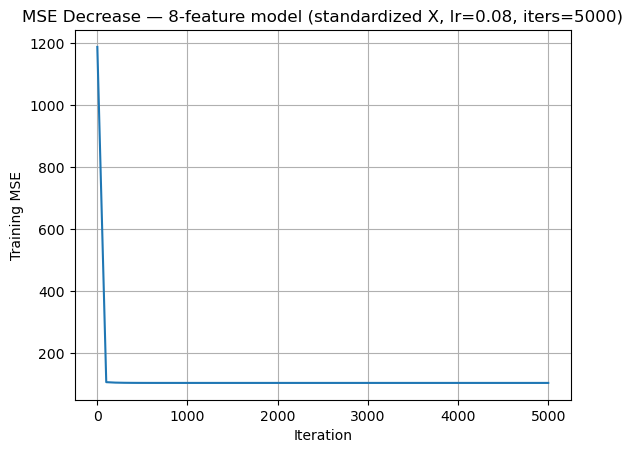

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# tiny wrapper: same update rule as your gd_multivariate, but logs MSE
def gd_multivariate_log(X, y, lr=0.05, n_iters=10000, log_every=100):
    # y_hat = X @ w + b; minimize MSE
    n, d = X.shape
    w = np.zeros(d)   # start from zeros
    b = 0.0
    hist = []
    for t in range(1, n_iters+1):
        yhat = X @ w + b
        err  = yhat - y
        dw = (2.0/n) * (X.T @ err)
        db = (2.0/n) * np.sum(err)
        w -= lr * dw
        b -= lr * db
        if (t % log_every == 0) or (t == 1):
            mse_val = float(np.mean((y - (X @ w + b))**2))
            hist.append((t, mse_val))
    return w, b, hist

# re-run best model to plot MSE decrease (use best from your grid search)
best_lr   = best['lr']
best_iter = int(best['iters'])

w_b, b_b, hist = gd_multivariate_log(X_train, y_train, lr=best_lr, n_iters=best_iter, log_every=100)

# plot
its  = [t for t, _ in hist]
mses = [v for _, v in hist]
plt.figure()
plt.plot(its, mses)
plt.xlabel("Iteration")
plt.ylabel("Training MSE")
plt.title(f"MSE Decrease — 8-feature model (standardized X, lr={best_lr}, iters={best_iter})")
plt.grid(True)
plt.show()

In [14]:
# Q2.4 Set 2
# Batch GD with backtracking (RAW X & y)
def gd_backtrack_raw(X, y, lr=1e-4, decay=0.5, n_iters=50_000, min_step=1e-16):
    n, d = X.shape
    w = np.zeros(d); b = 0.0
    def mse_(w,b): 
        r = y - (X @ w + b)
        return float((r @ r) / n)

    for _ in range(n_iters):
        yhat = X @ w + b
        err  = yhat - y
        dw = (2.0/n) * (X.T @ err)
        db = (2.0/n) * np.sum(err)

        step = lr
        L = mse_(w,b)
        # backtrack until loss decreases (and finite)
        while True:
            w_new = w - step*dw
            b_new = b - step*db
            L_new = mse_(w_new, b_new)
            if np.isfinite(L_new) and (L_new <= L):
                w, b = w_new, b_new
                break
            step *= decay
            if step < min_step:  # give up shrinking
                break
    return w, b

In [15]:
# 8 predictors, raw X, raw y
Xtr = train_df[X_cols].values
Xte = test_df[X_cols].values
ytr = y_train; yte = y_test

w,b = gd_backtrack_raw(Xtr, ytr, lr=1e-4, decay=0.5, n_iters=80_000)
ytr_hat, yte_hat = Xtr@w+b, Xte@w+b
print(f"b = {b:.6f}")
print("w =", np.round(w, 6))
print(f"MSE_train = {mse(ytr, ytr_hat):.6f}")
print(f"R2_train  = {r2(ytr, ytr_hat):.6f}")
print(f"MSE_test  = {mse(yte, yte_hat):.6f}")
print(f"R2_test   = {r2(yte, yte_hat):.6f}")

b = -0.001024
w = [ 0.118364  0.107386  0.086896 -0.204993  0.051447  0.011013  0.014769
  0.118434]
MSE_train = 104.537121
R2_train  = 0.622719
MSE_test  = 138.587448
R2_test   = 0.363516


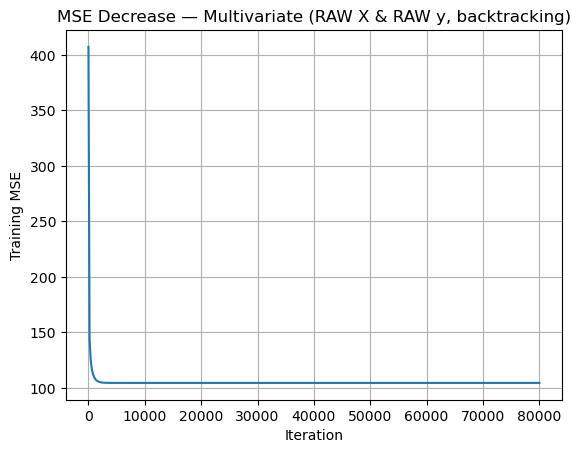

In [16]:
# backtracking with logging: record MSE only when a step is accepted
def gd_backtrack_raw_log(X, y, lr=1e-4, decay=0.5, n_iters=80_000, min_step=1e-16, log_every=200):
    n, d = X.shape
    w = np.zeros(d); b = 0.0

    def mse_(w,b):
        r = y - (X @ w + b)
        return float((r @ r) / n)

    hist = []  # (iter, mse)

    for it in range(1, n_iters+1):
        yhat = X @ w + b
        err  = yhat - y
        dw = (2.0/n) * (X.T @ err)
        db = (2.0/n) * np.sum(err)

        step = lr
        L = mse_(w,b)

        # backtrack until loss decreases (and finite)
        while True:
            w_new = w - step*dw
            b_new = b - step*db
            L_new = mse_(w_new, b_new)
            if np.isfinite(L_new) and (L_new <= L):
                w, b = w_new, b_new
                # log only when a step is accepted
                if (it % log_every == 0) or (it == 1):
                    hist.append((it, L_new))
                break
            step *= decay
            if step < min_step:  # give up shrinking
                break
    return w, b, hist

# Re-run with logging to make the figure
Xtr = train_df[X_cols].values
Xte = test_df[X_cols].values
ytr = y_train; yte = y_test

w_log, b_log, hist = gd_backtrack_raw_log(Xtr, ytr, lr=1e-4, decay=0.5, n_iters=80_000, log_every=200)

its  = [t for t,_ in hist]
mses = [v for _,v in hist]
plt.figure()
plt.plot(its, mses)
plt.xlabel("Iteration")
plt.ylabel("Training MSE")
plt.title("MSE Decrease — Multivariate (RAW X & RAW y, backtracking)")
plt.grid(True)
plt.show()